In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [2]:
file_path ="combined_eirgrid_data.xlsx"

In [3]:
df = pd.read_excel(file_path)
df

,date_time_bst,demand_mw,ewic_mw,moyle_mw,generation_mw,forecast_wind_mw,actual_wind_mw,region
0,2019-08-31 00:00:00,3383,-500.0,-79.0,4195,3010,2649,All Island
1,2019-08-31 00:15:00,3317,-500.0,-79.0,4132,3018,2616,All Island
2,2019-08-31 00:30:00,3262,-500.0,-80.0,4075,3026,2567,All Island
3,2019-08-31 00:45:00,3183,-500.0,-80.0,3995,3034,2460,All Island
4,2019-08-31 01:00:00,3116,-500.0,-80.0,3929,3030,2388,All Island
...,...,...,...,...,...,...,...,...
8607,2019-10-29 18:45:00,5759,-276.0,-338.0,6393,2374,2621,All Island
8608,2019-10-29 19:00:00,5685,-351.0,-338.0,6389,2358,2664,All Island
8609,2019-10-29 19:00:00,5685,-351.0,-338.0,6389,2358,2664,All Island
8610,2019-10-29 19:15:00,5614,-426.0,-338.0,6395,2356,2680,All Island


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8612 entries, 0 to 8611
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date_time_bst     8612 non-null   datetime64[ns]
 1   demand_mw         8612 non-null   int64         
 2   ewic_mw           8596 non-null   float64       
 3   moyle_mw          8596 non-null   float64       
 4   generation_mw     8612 non-null   int64         
 5   forecast_wind_mw  8612 non-null   int64         
 6   actual_wind_mw    8612 non-null   int64         
 7   region            8612 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 538.4+ KB


In [5]:

# Preprocess the data
def preprocess_data(df):
    # Convert date_time_bst to datetime
    df['date_time_bst'] = pd.to_datetime(df['date_time_bst'])
    
    # Set date_time_bst as index
    df.set_index('date_time_bst', inplace=True)
    
    # Remove commas from numeric columns and convert to float
    numeric_columns = ['demand_mw', 'ewic_mw', 'moyle_mw', 'generation_mw', 'forecast_wind_mw', 'actual_wind_mw']
    for col in numeric_columns:
        df[col] = df[col].replace(',', '', regex=True).astype(float)
    
    return df

In [6]:
df = preprocess_data(df)
df

,demand_mw,ewic_mw,moyle_mw,generation_mw,forecast_wind_mw,actual_wind_mw,region
date_time_bst,,,,,,,
2019-08-31 00:00:00,3383.0,-500.0,-79.0,4195.0,3010.0,2649.0,All Island
2019-08-31 00:15:00,3317.0,-500.0,-79.0,4132.0,3018.0,2616.0,All Island
2019-08-31 00:30:00,3262.0,-500.0,-80.0,4075.0,3026.0,2567.0,All Island
2019-08-31 00:45:00,3183.0,-500.0,-80.0,3995.0,3034.0,2460.0,All Island
2019-08-31 01:00:00,3116.0,-500.0,-80.0,3929.0,3030.0,2388.0,All Island
...,...,...,...,...,...,...,...
2019-10-29 18:45:00,5759.0,-276.0,-338.0,6393.0,2374.0,2621.0,All Island
2019-10-29 19:00:00,5685.0,-351.0,-338.0,6389.0,2358.0,2664.0,All Island
2019-10-29 19:00:00,5685.0,-351.0,-338.0,6389.0,2358.0,2664.0,All Island


In [7]:
def perform_eda(df):
    # Plot time series of demand and generation
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['demand_mw'], label='Demand')
    plt.plot(df.index, df['generation_mw'], label='Generation')
    plt.title('Demand vs Generation Over Time')
    plt.xlabel('Date')
    plt.ylabel('MW')
    plt.legend()
    plt.show()

    # Plot actual vs forecast wind
    plt.figure(figsize=(12, 6))
    plt.scatter(df['forecast_wind_mw'], df['actual_wind_mw'])
    plt.title('Forecast vs Actual Wind')
    plt.xlabel('Forecast Wind (MW)')
    plt.ylabel('Actual Wind (MW)')
    plt.plot([df['forecast_wind_mw'].min(), df['forecast_wind_mw'].max()], 
             [df['forecast_wind_mw'].min(), df['forecast_wind_mw'].max()], 
             'r--', lw=2)
    plt.show()

    # Correlation heatmap (excluding 'region' column)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()
    
    

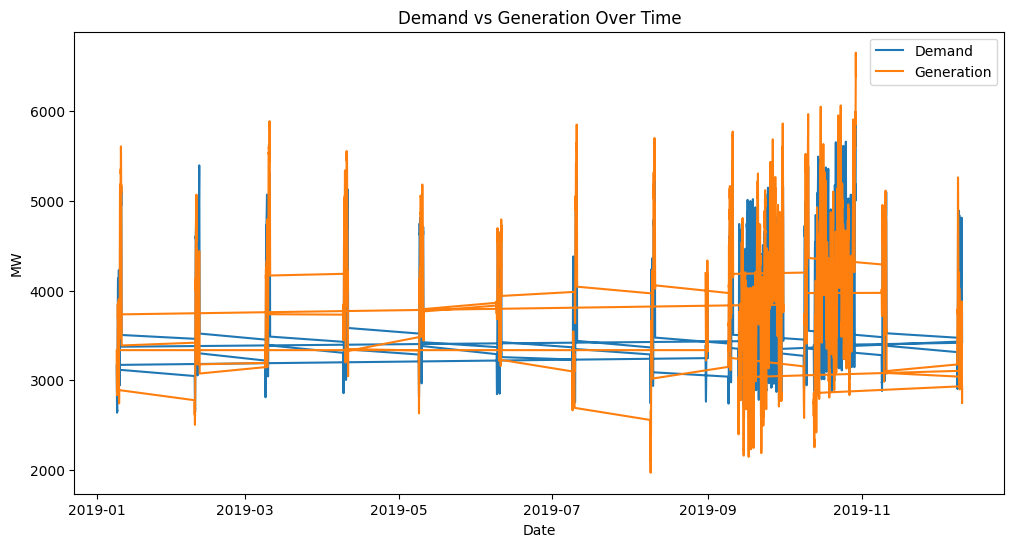

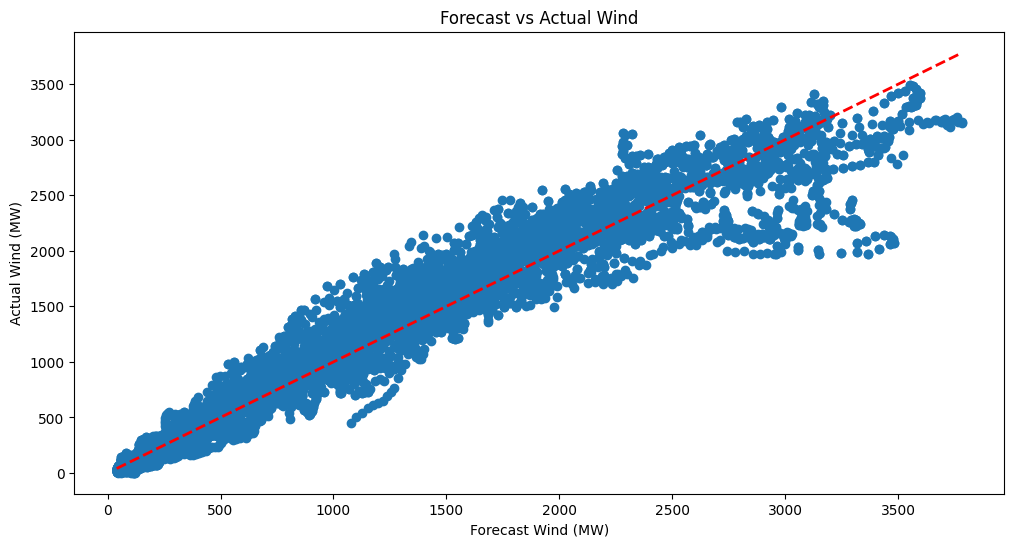

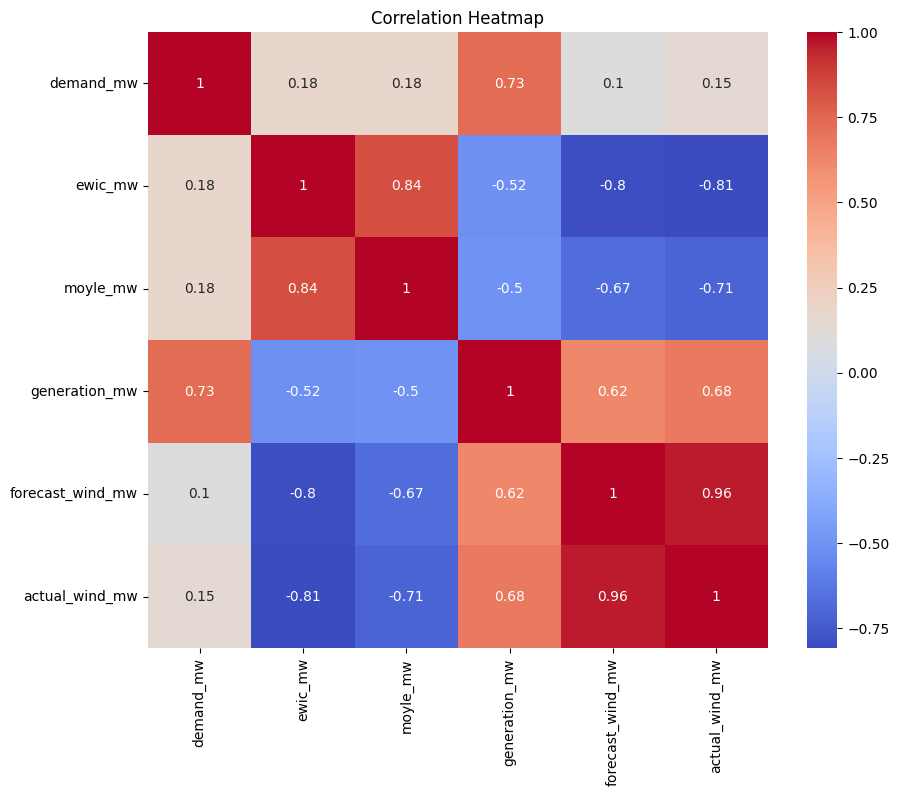

In [8]:

# Perform EDA
perform_eda(df)

In [9]:
# Feature engineering
def engineer_features(df):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['wind_forecast_error'] = df['actual_wind_mw'] - df['forecast_wind_mw']
    return df

In [10]:
# Engineer features
df = engineer_features(df)

In [11]:
features = ['hour', 'day_of_week', 'month', 'forecast_wind_mw', 'actual_wind_mw', 'wind_forecast_error']
X = df[features]
y = df['demand_mw']
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6889, 6), (1723, 6), (6889,), (1723,))

In [12]:
# Train a Random Forest model to predict demand
def train_model(df):
    features = ['hour', 'day_of_week', 'month', 'forecast_wind_mw', 'actual_wind_mw', 'wind_forecast_error']
    X = df[features]
    y = df['demand_mw']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Demand (MW)')
    plt.ylabel('Predicted Demand (MW)')
    plt.title('Actual vs Predicted Demand')
    plt.show()
    
    return model


Mean Absolute Error: 42.924090843766415
Root Mean Squared Error: 73.50685382095064


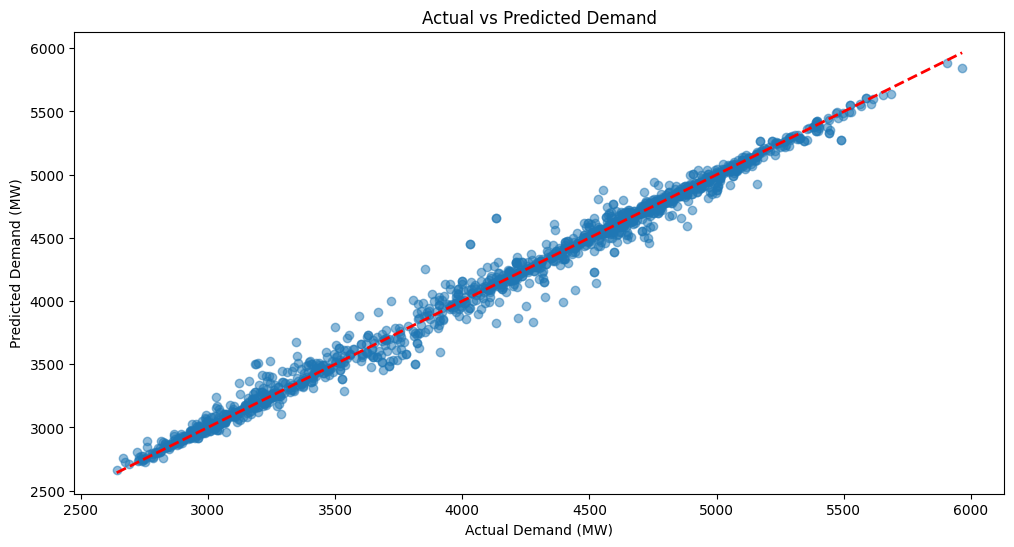

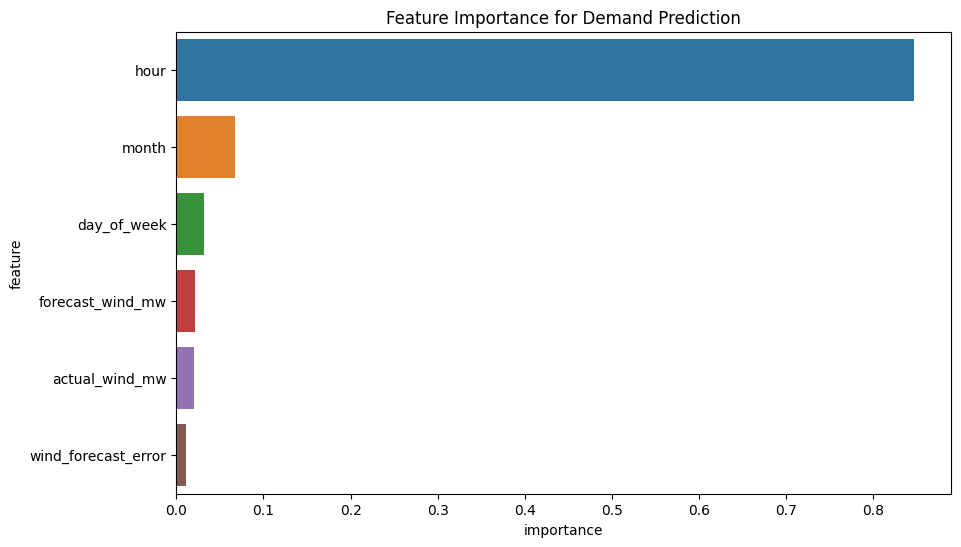

In [13]:

# Train model
model = train_model(df)
    
# Feature importance
features = ['hour', 'day_of_week', 'month', 'forecast_wind_mw', 'actual_wind_mw', 'wind_forecast_error']
importance = model.feature_importances_
feature_importance = pd.DataFrame({'feature': features, 'importance': importance})
feature_importance = feature_importance.sort_values('importance', ascending=False)
    
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Demand Prediction')
plt.show()

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_arima_model_batch(df, batch_size):
    # Use only the 'demand_mw' column for ARIMA
    data = df['demand_mw']
    
    # Split the data into train and test sets
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    
    # Automatically determine the best ARIMA order using the first batch
    auto_model = auto_arima(train[:batch_size], seasonal=True, m=24, 
                            start_p=0, start_q=0, max_p=5, max_q=5, max_d=2,
                            trace=True, error_action='ignore', suppress_warnings=True)
    
    best_order = auto_model.order
    print(f"Best ARIMA order: {best_order}")

    # Initialize variables for batch processing
    predictions = []
    
    for i in range(0, len(train), batch_size):
        # Slice the batch of data
        end = min(i + batch_size, len(train))
        batch_data = train[:end]  # Include data up to the current batch
        
        # Fit the ARIMA model with the current batch
        model = ARIMA(batch_data, order=best_order)
        results = model.fit()
        
        # Forecast for the length of the current batch
        steps = min(batch_size, len(test) - len(predictions))
        if steps > 0:
            batch_predictions = results.forecast(steps=steps)
            predictions.extend(batch_predictions)
    
    # Calculate prediction metrics
    predictions = predictions[:len(test)]  # Ensure predictions match test size
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    
    print(f"ARIMA - Mean Absolute Error: {mae}")
    print(f"ARIMA - Root Mean Squared Error: {rmse}")
    
    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, predictions, label='Predicted')
    plt.title('ARIMA: Actual vs Predicted Demand')
    plt.xlabel('Date')
    plt.ylabel('Demand (MW)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return results


In [15]:

# Compare models
def compare_models(df, rf_model, arima_model):
    # Prepare data for Random Forest predictions
    features = ['hour', 'day_of_week', 'month', 'forecast_wind_mw', 'actual_wind_mw', 'wind_forecast_error']
    X = df[features]
    y = df['demand_mw']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Make predictions
    rf_predictions = rf_model.predict(X_test)
    arima_predictions = arima_model.forecast(steps=len(y_test))
    
    # Calculate metrics
    rf_mae = mean_absolute_error(y_test, rf_predictions)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
    
    arima_mae = mean_absolute_error(y_test, arima_predictions)
    arima_rmse = np.sqrt(mean_squared_error(y_test, arima_predictions))
    
    print("Model Comparison:")
    print(f"Random Forest - MAE: {rf_mae}, RMSE: {rf_rmse}")
    print(f"ARIMA - MAE: {arima_mae}, RMSE: {arima_rmse}")
    
    # Plot predictions
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
    plt.plot(y_test.index, rf_predictions, label='Random Forest', alpha=0.7)
    plt.plot(y_test.index, arima_predictions, label='ARIMA', alpha=0.7)
    plt.title('Model Comparison: Actual vs Predicted Demand')
    plt.xlabel('Date')
    plt.ylabel('Demand (MW)')
    plt.legend()
    plt.show()



Mean Absolute Error: 42.924090843766415
Root Mean Squared Error: 73.50685382095064


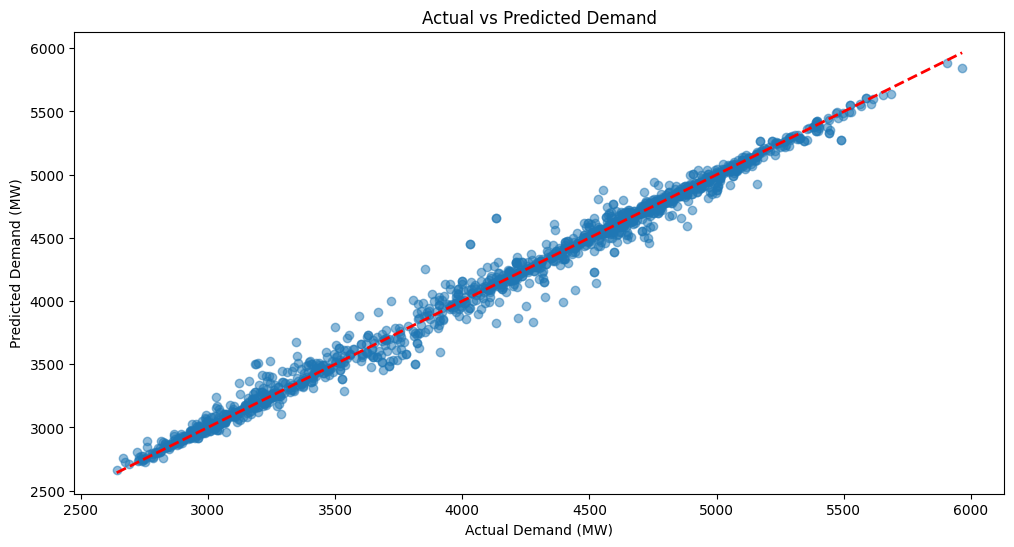

In [16]:

# Train Random Forest model
rf_model = train_model(df)
    


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=5760.496, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=5811.336, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=5327.582, Time=0.76 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=5519.042, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=5809.611, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=5329.202, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=5320.832, Time=3.74 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=5322.193, Time=5.12 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=5326.492, Time=0.97 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=5750.778, Time=2.45 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=5314.177, Time=5.18 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=5321.108, Time=1.18 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AIC=5315.520, Time=7.35 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=5319.959, Time=1.43 sec
 ARIMA(3,1,0)(2,0,0

d:\placement peroject\env2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\placement peroject\env2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\placement peroject\env2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\placement peroject\env2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\placement peroject\env2

ARIMA - Mean Absolute Error: 934.2199891278218
ARIMA - Root Mean Squared Error: 1183.186481605238


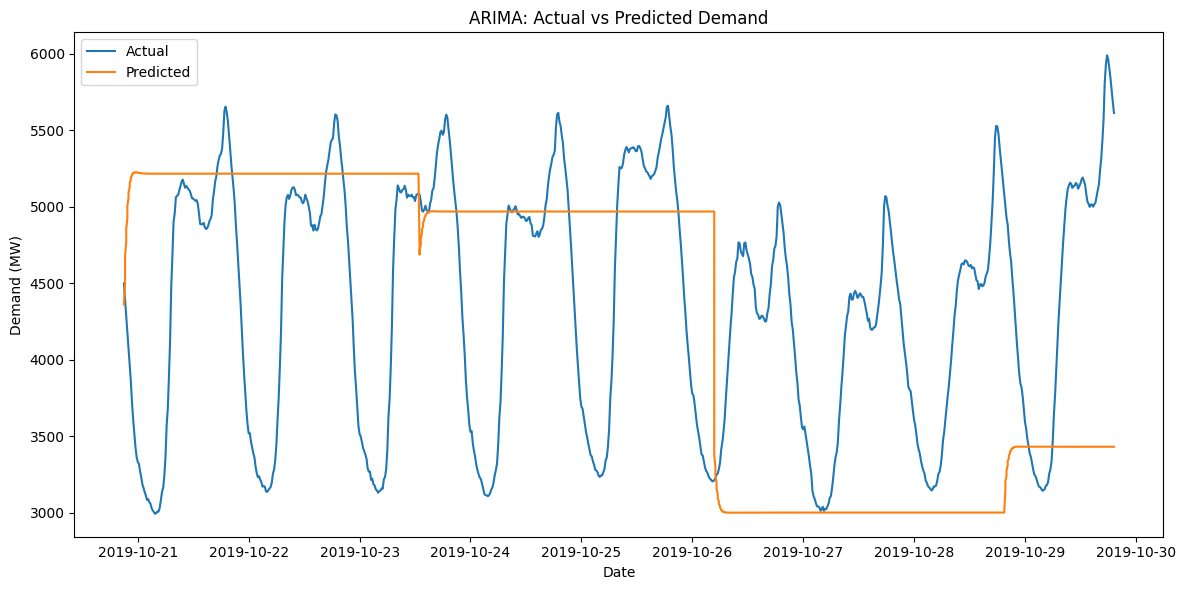

In [26]:
arima_model = train_arima_model_batch(df, batch_size=511)

    


d:\placement peroject\env2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Model Comparison:
Random Forest - MAE: 42.924090843766415, RMSE: 73.50685382095064
ARIMA - MAE: 684.4326141760715, RMSE: 787.9215538108296


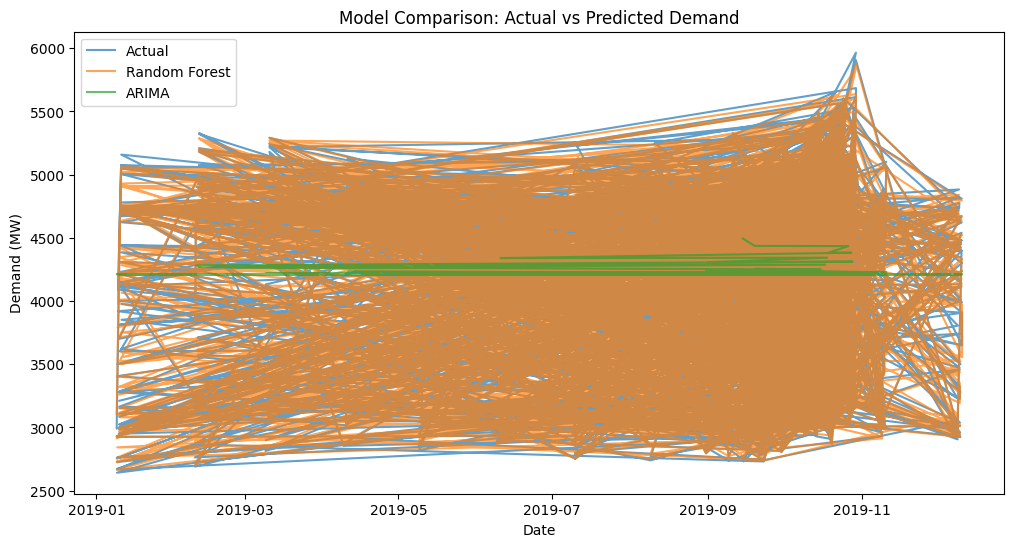

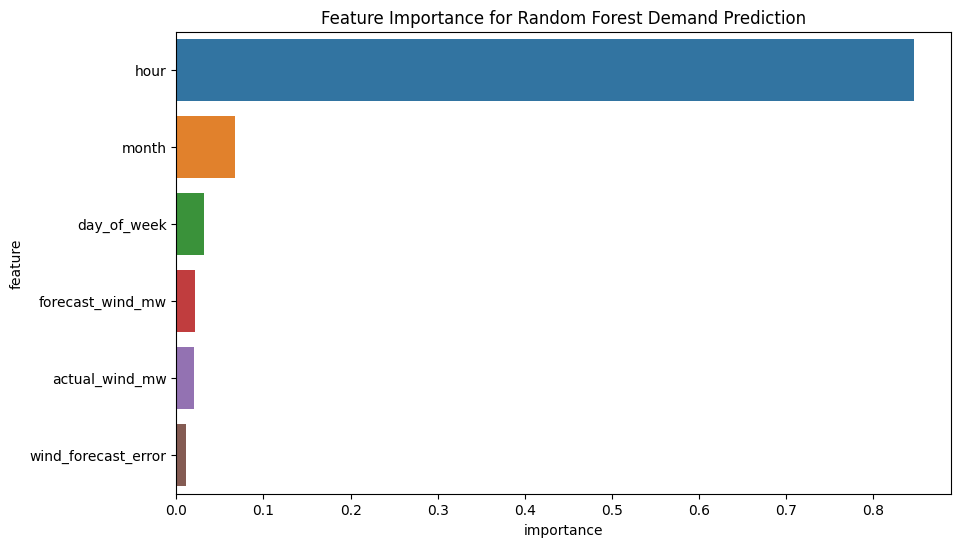

In [27]:
 # Compare models
compare_models(df, rf_model, arima_model)
    
# Feature importance (for Random Forest only)
features = ['hour', 'day_of_week', 'month', 'forecast_wind_mw', 'actual_wind_mw', 'wind_forecast_error']
importance = rf_model.feature_importances_
feature_importance = pd.DataFrame({'feature': features, 'importance': importance})
feature_importance = feature_importance.sort_values('importance', ascending=False)
    
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Random Forest Demand Prediction')
plt.show()